# Classifying News Content From The Huffington Post

**Authors:** Aarad Ashraf, Marilyn Cleveland, and Christopher Fornesa

**Date Submitted:** December 7, 2025

**Dataset:** HuffPost dataset

# A.1: Setup and Context

## A.1.A: Summary of Milestones 1 and 2

### Setup and Context
Data cleaning and preprocessing involved consolidating ambiguous categories, removing null values from the HuffPost dataset’s short description and headline columns. Then, we converted sentences into embeddings using label encoding and text vectorization as part of feature engineering and augmentation. We created a set of simple neural networks as the baseline and a set of custom neural networks using different sets of learning rates, batch sizes, dropout rates, and L2 regularization for up to 50 epochs. We also experimented with a set of pretrained models (RoBERTa, BERT, DistilBERT) using different sets of learning rates and batch sizes for 3 epochs each. Unlike the previous sets of modeling, the pretrained models used the Adam optimizer at a rate of 1e-5 per step, which customizes fine-tuning to each specific hyperparameter, resulting in more efficient modeling without overfitting.

## A.1.B: Final Preprocessing Pipeline

### Final Preprocessing Pipeline

We began preprocessing by loading the HuffPost dataset directly from Hugging Face. Then, we cleaned and normalized the text by removing null or empty values, both directly and through concatenating the headline and short description columns, converting the text to lowercase, and removing whitespace. Text was tokenized using text vectorization, while label encoding ensured that the category labels could be processed correctly by the model before being processed by the model, which applied additional tokenization specific to RoBERTa, such as byte-pair encoding, which took longer to process but yielded higher predictive power. Further augmentation was performed when we used a batch size of 32 and a max length of 96, though the latter only truncated a small portion of text observations, alongside an embedding dimension of 128, which is not as high as the standards for BERT or SentenceBERT (which often uses 384 dimensions).

### Imports (Both Preprocessing and Modeling)

In [ ]:
# Library imports for operating system, time, math, random, collections, seaborn, numpy, and matplotlib
import os
import time
import math
import random
from collections import Counter
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tensorflow import keras

# Imports for spacy, tqdm, and display
import spacy
from tqdm import tqdm
from IPython.display import display

# Imports for tensorflow and other related dependencies for layers
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

# Imports for label encoder and train test split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS
def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# Imports for metrics for evaluation and visualization
from sklearn.metrics import f1_score # Ensure f1_score is imported
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Import for Colab
from google.colab import files

In [ ]:
# Imports for dataset dictionaries and class labels to properly process data and class labels
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

In [ ]:
# Install once per new Colab runtime for proper evaluation
%pip -q install -U keras keras-hub tensorflow tensorflow-text datasets evaluate

In [ ]:
# Configuration and imports for keras using tensorflow
import keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# Imports for keras hub for models, evaluation, and modules from datasets
import keras_hub as kh
import evaluate
from datasets import load_dataset, Dataset, Features, Value, ClassLabel

# Imports for mixed precision numbers and setting figures for float16 for speed
from keras import mixed_precision                    # generally faster
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

# Print statements
print(huff_all)
print("Columns:", huff_all.column_names)
print("Total rows:", len(huff_all))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date'],
    num_rows: 200853
})
Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']
Total rows: 200853


### Data Exploration

In [ ]:
# Sanity check for an individual entry to ensure that data is proper
ex = huff_all[0]
print("One example:")
print("  category          :", ex.get("category"))
print("  headline          :", (ex.get("headline") or "")[:120])
print("  authors           :", (ex.get("authors") or "")[:120])
print("  short_description :", (ex.get("short_description") or "")[:120])
print("  date              :", ex.get("date"))

One example:
  category          : CRIME
  headline          : There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
  authors           : Melissa Jeltsen
  short_description : She left her husband. He killed their children. Just another day in America.
  date              : 2018-05-26 00:00:00


In [ ]:
# Save the dataset as a dataframe for analysis and manipulation
huff = pd.DataFrame(huff_all)
huff.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
# Get the shape of the dataset as-is
huff.shape

(200853, 6)

In [ ]:
# Get the category labels, reorder by alphabetical order, and obtain their counts
categories = sorted(huff['category'].unique())
category_counts = Counter(huff['category'])
for category in categories:
    print(f"{category}: {category_counts[category]}")

ARTS: 1509
ARTS & CULTURE: 1339
BLACK VOICES: 4528
BUSINESS: 5937
COLLEGE: 1144
COMEDY: 5175
CRIME: 3405
CULTURE & ARTS: 1030
DIVORCE: 3426
EDUCATION: 1004
ENTERTAINMENT: 16058
ENVIRONMENT: 1323
FIFTY: 1401
FOOD & DRINK: 6226
GOOD NEWS: 1398
GREEN: 2622
HEALTHY LIVING: 6694
HOME & LIVING: 4195
IMPACT: 3459
LATINO VOICES: 1129
MEDIA: 2815
MONEY: 1707
PARENTING: 8677
PARENTS: 3955
POLITICS: 32739
QUEER VOICES: 6314
RELIGION: 2556
SCIENCE: 2178
SPORTS: 4884
STYLE: 2254
STYLE & BEAUTY: 9649
TASTE: 2096
TECH: 2082
THE WORLDPOST: 3664
TRAVEL: 9887
WEDDINGS: 3651
WEIRD NEWS: 2670
WELLNESS: 17827
WOMEN: 3490
WORLD NEWS: 2177
WORLDPOST: 2579


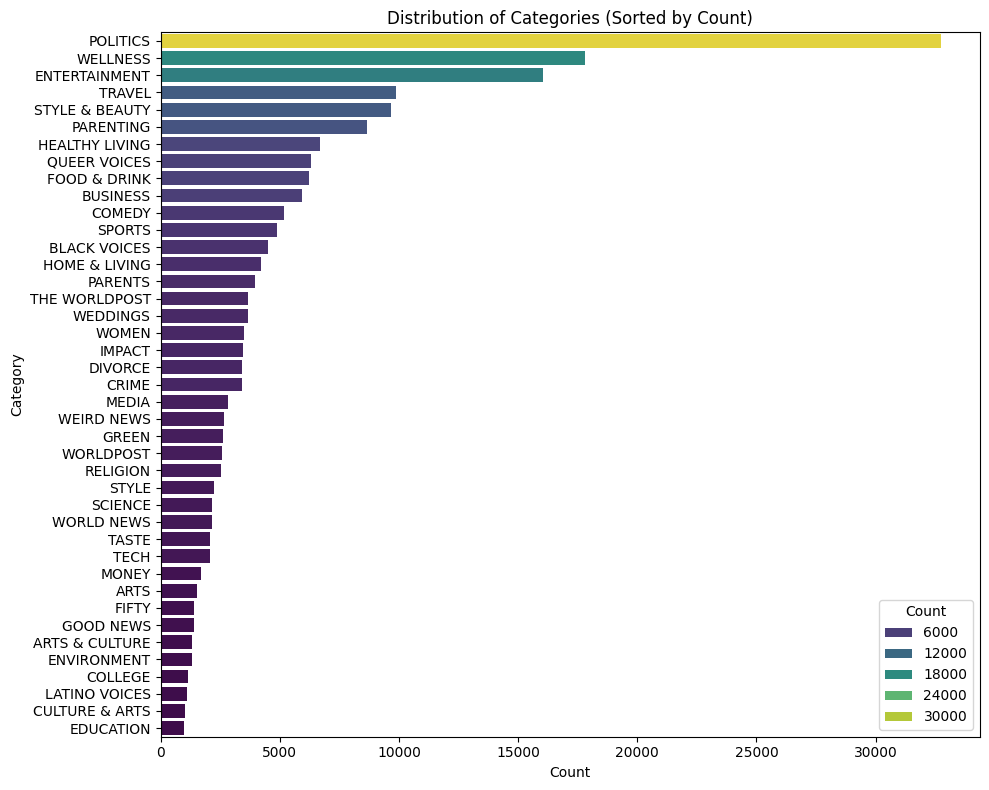

In [ ]:
# Create and sort a dataframe in descending order by value count
label_counts = huff['category'].value_counts()
label_counts_df = label_counts.reset_index()

# Rename the columns to explicitly set 'Category' and 'Count'
label_counts_df.columns = ['Category', 'Count']

# Plot the label counts as a horizontal bar plot using seaborn with the "viridis" colormap based on Count
plt.figure(figsize=(10, 8)) # Adjust figure size for horizontal plot
sns.barplot(x='Count', y='Category', hue='Count', data=label_counts_df, palette='viridis', dodge=False)
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Distribution of Categories (Sorted by Count)')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

### Data Cleaning and Feature Engineering

In [ ]:
# Only keep the first duplicate short_descriptions
huff = huff.drop_duplicates(subset='short_description', keep='first')
print(f"New shape: {huff.shape}")
huff.head()

New shape: (178353, 6)


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
# Concatenate Headline and Short Description
huff['text'] = huff['headline'] + ' ' + huff['short_description']
huff.head()

,category,headline,authors,link,short_description,date,text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...


In [ ]:
# Remove 'headline' and 'short_description' columns
huff = huff.drop(columns=['headline', 'short_description'])
print(f"New shape of Huff dataframe after removing duplicates and consolidating columns: {huff.shape}")
huff.head()

New shape of Huff dataframe after removing duplicates and consolidating columns: (178353, 5)


,category,authors,link,date,text
0,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...


In [ ]:
# Strip whitespace, convert to lowercase if appropriate, and remove empty samples
huff['text'] = huff['text'].str.strip().str.lower()
huff = huff[huff['text'] != '']
huff.head()

,category,authors,link,date,text
0,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26,there were 2 mass shootings in texas last week...
1,ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26,will smith joins diplo and nicky jam for the 2...
2,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26,hugh grant marries for the first time at age 5...
3,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,2018-05-26,jim carrey blasts 'castrato' adam schiff and d...
4,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,2018-05-26,julianna margulies uses donald trump poop bags...


In [ ]:
# Consolidate the World News columns
world_news_columns = ['THE WORLDPOST', 'WORLDPOST', 'WORLD NEWS']
huff['category'] = huff['category'].replace(world_news_columns, 'WORLD NEWS')

# Consolidate the Style & Beauty columns
style_beauty_columns = ['STYLE', 'STYLE & BEAUTY']
huff['category'] = huff['category'].replace(style_beauty_columns, 'STYLE & BEAUTY')

# Consolidate the Education columns
education_columns = ['COLLEGE', 'EDUCATION']
huff['category'] = huff['category'].replace(education_columns, 'EDUCATION')

# Consolidate the Parenting columns
parenting_columns = ['PARENTING', 'PARENTS']
huff['category'] = huff['category'].replace(parenting_columns, 'PARENTING')

# Consolidate the Environment columns
environment_columns = ['GREEN', 'ENVIRONMENT']
huff['category'] = huff['category'].replace(environment_columns, 'ENVIRONMENT')

# Consolidate the Arts & Culture columns
arts_culture_columns = ['CULTURE & ARTS', 'ARTS & CULTURE', 'ARTS']
huff['category'] = huff['category'].replace(arts_culture_columns, 'ARTS & CULTURE')

# Consolidate the Wellness and Healthy Living columns into Wellness
wellness_columns = ['HEALTHY LIVING', 'WELLNESS']
huff['category'] = huff['category'].replace(wellness_columns, 'WELLNESS')

# Consolidate the Food & Drink and Taste columns into Taste
taste_columns = ['TASTE', 'FOOD & DRINK']
huff['category'] = huff['category'].replace(taste_columns, 'FOOD & DRINK')

# Consolidate the Entertainment and Media columns into Entertainment
entertainment_columns = ['ENTERTAINMENT', 'MEDIA']
huff['category'] = huff['category'].replace(entertainment_columns, 'ENTERTAINMENT')


In [ ]:
# Print the new changes with data about the categories and shape of the new dataset
print(f" There are now {len(huff['category'].unique())} categories after consolidation")
print(f" The shape of the dataframe after consolidating categories: {huff.shape}")
huff.head()

 There are now 30 categories after consolidation
 The shape of the dataframe after consolidating categories: (178353, 5)


,category,authors,link,date,text
0,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26,there were 2 mass shootings in texas last week...
1,ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26,will smith joins diplo and nicky jam for the 2...
2,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26,hugh grant marries for the first time at age 5...
3,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,2018-05-26,jim carrey blasts 'castrato' adam schiff and d...
4,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,2018-05-26,julianna margulies uses donald trump poop bags...


### Training/Validation/Testing Split

In [ ]:
# Make a copy to manipulate the dataset
huff_copy = huff.copy()

In [ ]:
# Split the Dataset
random_seed = 42

# Initial train/test split with text X and category y, split randomly, using a random seed, and stratified by y
X_train, X_temp, y_train, y_temp = train_test_split(
    huff_copy["text"],
    huff_copy["category"],
    test_size = 0.3,  # 70/30 split
    random_state = random_seed,
    stratify = huff_copy["category"]
)

# Train/test split for validation/test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size = 0.5,  # 15/15 split
    random_state = random_seed,
    stratify = y_temp
)

In [ ]:
# Your code here; add as many cells as you need but make it clear what the structure is.

# Conversion to DataFrames for processing
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)

# Initialize LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder on each unique category to determine the different classes
huff_copy['label'] = le.fit_transform(huff_copy['category'])
num_classes = len(le.classes_)
print(f" The classes are: {le.classes_}")
print(f" The amount of classes is {num_classes}")

 The classes are: ['ARTS & CULTURE' 'BLACK VOICES' 'BUSINESS' 'COMEDY' 'CRIME' 'DIVORCE'
 'EDUCATION' 'ENTERTAINMENT' 'ENVIRONMENT' 'FIFTY' 'FOOD & DRINK'
 'GOOD NEWS' 'HOME & LIVING' 'IMPACT' 'LATINO VOICES' 'MONEY' 'PARENTING'
 'POLITICS' 'QUEER VOICES' 'RELIGION' 'SCIENCE' 'SPORTS' 'STYLE & BEAUTY'
 'TECH' 'TRAVEL' 'WEDDINGS' 'WEIRD NEWS' 'WELLNESS' 'WOMEN' 'WORLD NEWS']
 The amount of classes is 30


In [ ]:
# Determine Max_Length (a.k.a. 95th percentile)
lengths = huff_copy['text'].apply(lambda x: len(str(x).split()))
max_len = int(np.percentile(lengths, 95))
print("95th percentile length:", max_len)
median_len = int(np.median(lengths))
print("Median length:", median_len)
mean_len = int(np.mean(lengths))
print("Mean length:", mean_len)

95th percentile length: 56
Median length: 29
Mean length: 31


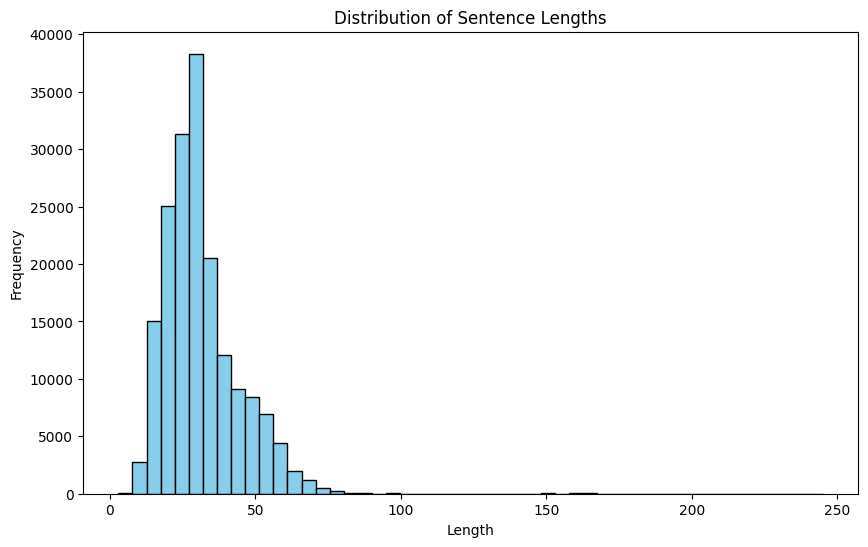

In [ ]:
# Plot the distribution of lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

In [ ]:
# Compute the vocabulary size
unique_words = set()
for text in huff_copy['text']:
    words = text.split()
    unique_words.update(words)
vocab_size = len(unique_words)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 235259


### Label Encoding

In [ ]:
# Fit LabelEncoder on training labels and transform all sets
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Set specific hyperparameters
num_classes = len(le.classes_) # Get the number of classes from the LabelEncoder
max_tokens  = vocab_size        # small vocab for speed
seq_len     = max_len          # short sequence for quick training
embed_dim   = 128          # modest embedding size

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### Text Vectorization

In [ ]:
# Keras TextVectorization
text_vectorizer = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=seq_len,
    standardize="lower_and_strip_punctuation",
    split="whitespace"
)
text_vectorizer.adapt(X_train["text"].values)  # fit only on train

In [ ]:
# Vectorize splits
def vec(series):
    return text_vectorizer(series.values)

# Obtain the vectors for training, validation, and testing
Xtr_vec = vec(X_train["text"])
Xval_vec = vec(X_val["text"])
Xte_vec  = vec(X_test["text"])

# One-hot labels for training with categorical_crossentropy
ytr_cat  = keras.utils.to_categorical(y_train_encoded, num_classes)
yval_cat = keras.utils.to_categorical(y_val_encoded, num_classes)
yte_cat  = keras.utils.to_categorical(y_test_encoded, num_classes)

### Post-Vectorization Analysis

In [ ]:
# Post Vectorization Sanity Check

# Get sample texts (first 3 samples)
sample_texts = huff_copy["text"].iloc[:3].astype(str).tolist()

# Get the sample tensor using the sample texts
sample_tensor = tf.constant(sample_texts)

# Get the results of text vectorization
vec_out = text_vectorizer(sample_tensor)

# Loop through the output
for i, (orig, vec_row) in enumerate(zip(sample_texts, vec_out.numpy())):
    print(f"--- SAMPLE {i} ---")
    print("original:", orig[:120].replace("\n"," ") + "...")
    print("vector  :", vec_row[:40], "...")
    print("length  :", len(vec_row))
    print()


--- SAMPLE 0 ---
original: there were 2 mass shootings in texas last week, but only 1 on tv she left her husband. he killed their children. just an...
vector  : [  71   70  385 1401 3194    7  691  131  108   27  114  382   11  467
   88  463   52  648   59  581   48  145   55  182   64    7  205    0
    0    0    0    0    0    0    0    0    0    0    0    0] ...
length  : 56

--- SAMPLE 1 ---
original: will smith joins diplo and nicky jam for the 2018 world cup's official song of course it has a song....
vector  : [   44  1629  2900 38226     6 30914  5960     9     2  2558    82  6592
   987  1021     5   584    15    39     4  1021     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0] ...
length  : 56

--- SAMPLE 2 ---
original: hugh grant marries for the first time at age 57 the actor and his longtime girlfriend anna eberstein tied the knot in a ...
vector  : [ 5586  5408  7695     9     2    79    58    22   4

In [ ]:
# Get the value counts for each label
counts = huff_copy["label"].value_counts()
print(counts)

label
17    29131
27    22746
7     15533
16    12065
22    10645
24     9377
10     8094
29     7068
18     5399
2      5056
3      4373
21     4165
1      4070
12     4003
25     3645
5      3402
8      3353
0      3206
13     3048
28     3030
4      2667
26     2156
23     1984
6      1812
19     1774
20     1761
15     1705
9      1042
11     1026
14     1017
Name: count, dtype: int64


In [ ]:
# Map the original labels to their encoded integer values.
  # The LabelEncoder 'le' already holds the mapping after being fitted.
  # 'le.classes_' provides the original category names in sorted order of their integer labels.
label_map_df = pd.DataFrame({
    'Label': range(len(le.classes_)),  # Integer labels are 0 to num_classes - 1
    'Category': le.classes_            # Original category names
})

print("Mapping of Encoded Labels to Original Categories:")
print(label_map_df)

Mapping of Encoded Labels to Original Categories:
    Label        Category
0       0  ARTS & CULTURE
1       1    BLACK VOICES
2       2        BUSINESS
3       3          COMEDY
4       4           CRIME
5       5         DIVORCE
6       6       EDUCATION
7       7   ENTERTAINMENT
8       8     ENVIRONMENT
9       9           FIFTY
10     10    FOOD & DRINK
11     11       GOOD NEWS
12     12   HOME & LIVING
13     13          IMPACT
14     14   LATINO VOICES
15     15           MONEY
16     16       PARENTING
17     17        POLITICS
18     18    QUEER VOICES
19     19        RELIGION
20     20         SCIENCE
21     21          SPORTS
22     22  STYLE & BEAUTY
23     23            TECH
24     24          TRAVEL
25     25        WEDDINGS
26     26      WEIRD NEWS
27     27        WELLNESS
28     28           WOMEN
29     29      WORLD NEWS


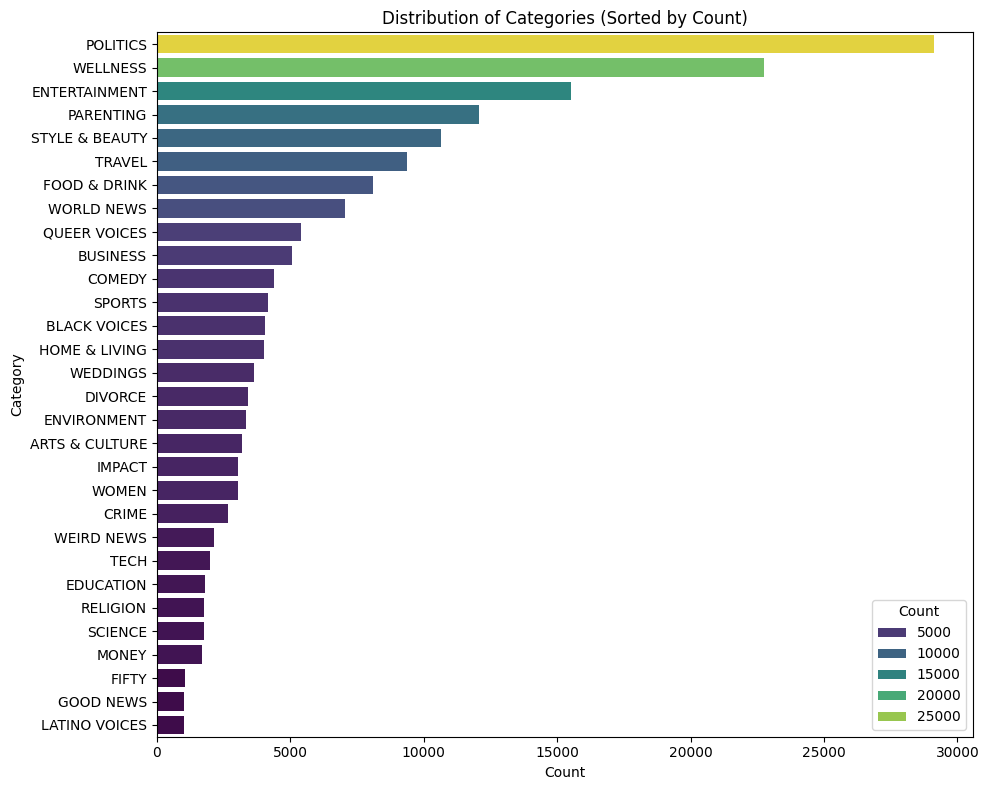

In [ ]:
# Convert the label counts to a DataFrame for easier plotting with seaborn
label_counts = huff_copy['category'].value_counts()
label_counts_df = label_counts.reset_index()
# Rename the columns to clearly distinguish between category names and counts
label_counts_df.columns = ['Category', 'Count']

# Merge with the label map on the 'Category' column (which holds the string names in both DataFrames)
label_counts_df = pd.merge(label_counts_df, label_map_df, on='Category')

# Sort the DataFrame by Count in descending order for plotting
label_counts_df_sorted = label_counts_df.sort_values('Count', ascending=False)

# Plot the label counts as a horizontal bar plot using seaborn with the "viridis" colormap based on Count
plt.figure(figsize=(10, 8)) # Adjust figure size for horizontal plot
sns.barplot(x='Count', y='Category', hue='Count', data=label_counts_df_sorted, palette='viridis', dodge=False)
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Distribution of Categories (Sorted by Count)')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [ ]:
# Get the set shapes
print("X train shape:")
print(Xtr_vec.shape)
print("X validation shape:")
print(Xval_vec.shape)
print("X test shape:")
print(Xte_vec.shape)
print()
print("y train shape:")
print(ytr_cat.shape)
print("y validation shape:")
print(yval_cat.shape)
print("y test shape:")
print(yte_cat.shape)

X train shape:
(124847, 56)
X validation shape:
(26753, 56)
X test shape:
(26753, 56)

y train shape:
(124847, 30)
y validation shape:
(26753, 30)
y test shape:
(26753, 30)


In [ ]:
# Iterate through each unique category
for index, row in label_map_df.iterrows():
    category_label = row['Label']
    category_name = row['Category']

    # Get all examples for the current category
    category_examples = huff_copy[huff_copy['label'] == category_label]
    print(f"Category: {category_name} (Label: {category_label})")

    # Limit to 5 examples for printing, ensure there are enough examples
    for i in range(min(5, len(category_examples))): # Use min to prevent IndexError if fewer than 5 examples
        example = category_examples.iloc[i] # Get the i-th example for this category

        text = example['text']
        # The 'category' variable is not used in the print below, but keeping for potential future use or context.

        # Extract the first sentence from the current example's text
        sentences_list = [s.strip() for s in text.split('.') if s.strip()]

        if sentences_list:
            sentence = sentences_list[0] + '.'
        else:
            sentence = text # Fallback to full text if no valid sentences found

        print(f"Sentence {i+1} from example {i+1}: {sentence}") # Clarify output

    print()

Category: ARTS & CULTURE (Label: 0)
Sentence 1 from example 1: modeling agencies enabled sexual predators for years, former agent says in the 1980s and '90s, carolyn kramer said she and her colleagues knew about allegedly predatory photographers, and sent their models to them anyway.
Sentence 2 from example 2: actor jeff hiller talks “bright colors and bold patterns” and more (audio) this week i talked with actor jeff hiller about the hit off broadway play bright colors and bold patterns that he’ll be joining.
Sentence 3 from example 3: new yorker cover puts trump 'in the hole' after 'racist' comment the president reportedly referred to groups of immigrants as coming from "shithole countries.
Sentence 4 from example 4: j.
Sentence 5 from example 5: man surprises girlfriend by drawing them in different animation styles what a colorful christmas gift.

Category: BLACK VOICES (Label: 1)
Sentence 1 from example 1: warriors coach steve kerr calls nfl ban on protests 'fake patriotism' forbid

# A.2: Model Selection and Retraining

## A.2.A: Final Architecture and Justification

### Final Architecture and Justification
We selected the RoBERTa-base pretrained encoder with all frozen layers as our primary pretrained architecture using imbalanced, label-encoded, and text-vectorized sentence embeddings. Among the other pretrained models, RoBERTa consistently delivered the strongest metrics in our experiments. We achieved the below results from our best RoBERTa run, and it was higher than every DistilBERT and BERT run. We used validation accuracy, minimum validation weighted F1 score, minimum validation loss, test loss, test accuracy, test weighted F1-score, and the testing macro F1 score and per-class testing F1 scores to evaluate the overall and per-class predictive performance of the RoBERTa-base model. Other than the higher model results, RoBERTa was chosen because it features more robust training and preserves full model capacity.

## A.2.B: Hyperparameter Definitions

### Hyperparameters
For this model, we used a random seed of 42 and a learning rate of 1e-5, which was sufficiently deep enough to get the best results from the RoBERTa text classifier, but shallow enough to learn quickly. Additionally, applying this learning rate to the Adam optimizer led to a balance of sufficient learning and careful consideration for each step of that optimization process. The batch size of 32 was small enough to effectively for the model to gauge the underlying trends in the HuffPost data, while being large enough to where compute would not be an issue, while the evaluation batch size of 64 allowed for faster processing of the model on the test data. The maximum length of 96 was also far higher than the 95% threshold originally suggested in Milestone 2 (at 56), but was small enough to not severely overfit on outlier text (in terms of size) while being large enough to effectively capture the sentiment within the text, even in longer descriptions. Given that the model had begun to overfit at the third epoch in previous experiments using RoBERTa or other pretrained models, we chose not to experiment with more than 3 epochs. No dropout rates, weight decay, or L2 regularization were included as we did not use custom layers and chose to use a pretrained classifier model.

In [ ]:
# Hyperparameters for the RoBERTa text classifier
SEED        = 42
SUBSET_FRAC = 0.25   # 0.25 to train and test on 25% of whole dataset during development;  set to 1.0 for full dataset (do this by the end)
MAX_LEN     = 96
BATCH       = 32
EVAL_BATCH  = 64
EPOCHS      = 3
keras.utils.set_random_seed(SEED)

## A.3.C: Optimization Strategy

Optimizations
Adam optimizer was used to adjust the parameters and minimize loss in order to find the most efficient path using derivatives of the loss function, increasing stability. However, Adam optimizer functions differently from traditional learning rate reduction in that it functions per hyperparameter, rather than globally. The result is speed and efficiency (compared to stochastic gradient descent) which is partially why the model converges within 3 epochs, the ability to handle sparse gradients (situations with infrequent features), adaptive learning rates per individual parameters, and minimal hyperparameter tuning compared to default settings (according to <a href="https://medium.com/@weidagang/demystifying-the-adam-optimizer-in-machine-learning-4401d162cb9e">Demystifying the Adam Optimizer in Machine Learning</a>).

## A.3.D: Callbacks

### Callbacks
The sole callback that we utilized in this model was using early stopping to monitor the validation loss for each epoch with a patience of 3, meaning that early stopping would be implemented if improvements in the validation loss did not occur. In theory, this could have helped to prevent overfitting and improved training stability by ensuring that extremely low improvements (or no improvement at all) in validation loss (which may not yield improvements for test accuracy) were ignored within three epochs. However, because we limited testing to three epochs, early stopping was not a factor in choosing the lowest validation loss.

## A.3.E: Retraining From Scratch

In [ ]:
# Build preprocessor + classifier
p4_final_preproc = kh.models.RobertaTextClassifierPreprocessor.from_preset(
    "roberta_large_en",
    sequence_length=MAX_LEN
)

# Corrected: Get unique classes from the 'category' column of y_train
num_classes = int(len(pd.unique(y_train['category'])))

# The RoBERTa model with frozen layers
p4_final_model = kh.models.RobertaTextClassifier.from_preset(
    "roberta_large_en",
    num_classes=num_classes,
    preprocessor=p4_final_preproc
)

# Use accuracy as the metric for optimization
p4_final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Encode labels to integer class IDs
p4_final_le = LabelEncoder()
p4_final_y_train_np = p4_final_le.fit_transform(y_train).astype("int32").reshape(-1)
p4_final_y_val_np   = p4_final_le.transform(y_val).astype("int32").reshape(-1)
p4_final_y_test_np  = p4_final_le.transform(y_test).astype("int32").reshape(-1)

# Class weights keyed by int class IDs
p4_final_classes = np.unique(p4_final_y_train_np)
p4_final_weights = compute_class_weight(class_weight="balanced", classes=p4_final_classes, y=p4_final_y_train_np)

100%|██████████| 446/446 [00:00<00:00, 928kB/s]


100%|██████████| 686/686 [00:00<00:00, 1.32MB/s]


100%|██████████| 0.99M/0.99M [00:01<00:00, 775kB/s]


100%|██████████| 446k/446k [00:01<00:00, 425kB/s]


100%|██████████| 1.32G/1.32G [01:24<00:00, 16.7MB/s]
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# Prepare raw-text inputs as Python lists
p4_final_X_train_list = X_train['text'].astype(str).tolist()
p4_final_X_val_list   = X_val['text'].astype(str).tolist()
p4_final_X_test_list  = X_test['text'].astype(str).tolist()

In [ ]:
# Training RoBERTa text classifier using the training and validation splits.
p4_final_start_time = time.time()

# Callback for early stopping
p4_final_cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

# History for the RoBERTa text classifier model
p4_final_history = p4_final_model.fit(
    p4_final_X_train_list, p4_final_y_train_np, # training splits.
    validation_data=(p4_final_X_val_list, p4_final_y_val_np), # validation splits.
    epochs=EPOCHS,  # 3 epochs.
    batch_size=BATCH, # batch size of 32.
    callbacks=p4_final_cb,  # callbacks (early stopping, but unused).
    class_weight=None,  # no class weighting.
    verbose=1,
)

Epoch 1/3
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 811s 166ms/step - accuracy: 0.7248 - loss: 0.9769 - val_accuracy: 0.7589 - val_loss: 0.8041
Epoch 2/3
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 523s 133ms/step - accuracy: 0.8004 - loss: 0.6645 - val_accuracy: 0.7705 - val_loss: 0.7742
Epoch 3/3
3902/3902 ━━━━━━━━━━━━━━━━━━━━ 523s 134ms/step - accuracy: 0.8472 - loss: 0.5037 - val_accuracy: 0.7690 - val_loss: 0.8103


In [ ]:
# Evaluating RoBERTa text classifier on the testing split
p4_final_test_loss, p4_final_test_acc = p4_final_model.evaluate(p4_final_X_test_list, p4_final_y_test_np, batch_size=EVAL_BATCH, verbose=0)
p4_final_y_test_logits = p4_final_model.predict(p4_final_X_test_list, batch_size=EVAL_BATCH, verbose=0)
p4_final_y_test_pred   = np.argmax(p4_final_y_test_logits, axis=1)

# Calculate Test F1 scores
p4_final_test_weighted_f1 = f1_score(p4_final_y_test_np, p4_final_y_test_pred, average="weighted")
p4_final_test_macro_f1 = f1_score(p4_final_y_test_np, p4_final_y_test_pred, average="macro")

# Metrics at min validation loss
p4_final_val_loss_hist = p4_final_history.history["val_loss"]
p4_final_acc_hist      = p4_final_history.history["accuracy"] # Get training accuracy history
p4_final_val_acc_hist  = p4_final_history.history.get("val_accuracy")

p4_final_min_idx       = int(np.argmin(p4_final_val_loss_hist))
p4_final_min_val_loss  = float(p4_final_val_loss_hist[p4_final_min_idx])
p4_final_min_val_acc   = float(p4_final_val_acc_hist[p4_final_min_idx]) if p4_final_val_acc_hist is not None else float(p4_final_acc_hist[p4_final_min_idx])
p4_final_min_train_acc = float(p4_final_acc_hist[p4_final_min_idx]) # Training accuracy at the epoch of min val loss

# Validation F1 scores (with best weights restored)
p4_final_y_val_logits = p4_final_model.predict(p4_final_X_val_list, batch_size=EVAL_BATCH, verbose=0)
p4_final_y_val_pred   = np.argmax(p4_final_y_val_logits, axis=1)
p4_final_val_weighted_f1 = f1_score(p4_final_y_val_np, p4_final_y_val_pred, average="weighted")
p4_final_val_macro_f1 = f1_score(p4_final_y_val_np, p4_final_y_val_pred, average="macro")

# Training F1 scores (with best weights restored)
p4_final_y_train_logits = p4_final_model.predict(p4_final_X_train_list, batch_size=EVAL_BATCH, verbose=0)
p4_final_y_train_pred   = np.argmax(p4_final_y_train_logits, axis=1)
p4_final_train_weighted_f1 = f1_score(p4_final_y_train_np, p4_final_y_train_pred, average="weighted")
p4_final_train_macro_f1 = f1_score(p4_final_y_train_np, p4_final_y_train_pred, average="macro")

# Assign the results to a dictionary
p4_final_results = {
    "min_val_loss": p4_final_min_val_loss,
    "training_accuracy_at_min_val_loss": p4_final_min_train_acc,
    "validation_accuracy_at_min_val_loss": p4_final_min_val_acc,
    "val_weighted_f1_score": float(p4_final_val_weighted_f1),
    "val_macro_f1_score": float(p4_final_val_macro_f1),
    "train_weighted_f1_score": float(p4_final_train_weighted_f1),
    "train_macro_f1_score": float(p4_final_train_macro_f1),
    "test_loss": float(p4_final_test_loss),
    "test_accuracy": float(p4_final_test_acc),
    "test_weighted_f1_score": float(p4_final_test_weighted_f1),
    "test_macro_f1_score": float(p4_final_test_macro_f1),
    "epochs_trained": int(len(p4_final_history.history["loss"])),
    "training_time": float(time.time() - p4_final_start_time),
}

# Print statements for the metrics
print(f"\nTraining Accuracy (at min val loss epoch): {p4_final_min_train_acc:.4f}")
print(f"Validation Accuracy (at min val loss): {p4_final_min_val_acc:.4f}")
print(f"Test Accuracy (RoBERTa): {p4_final_test_acc:.4f}")
print(f"\nTraining Weighted F1 Score: {p4_final_train_weighted_f1:.4f}")
print(f"Training Macro F1 Score: {p4_final_train_macro_f1:.4f}")
print(f"Validation Weighted F1 Score: {p4_final_val_weighted_f1:.4f}")
print(f"Validation Macro F1 Score: {p4_final_val_macro_f1:.4f}")
print(f"Test Weighted F1-Score: {p4_final_test_weighted_f1:.4f}")
print(f"Test Macro F1-Score: {p4_final_test_macro_f1:.4f}")
print(f"\nTest Loss (RoBERTa): {p4_final_test_loss:.4f}")

# Print the final results
print("\nKerasHub RoBERTa Results:")
print(p4_final_results)

# Print the classification report
print("\nClassification Report:")
print(classification_report(p4_final_y_test_np, p4_final_y_test_pred))

# Print the elapsed time taken
p4_final_elapsed = time.time() - p4_final_start_time
print("\nElapsed time:", time.strftime("%H:%M:%S", time.gmtime(p4_final_elapsed)))


Training Accuracy (at min val loss epoch): 0.8004
Validation Accuracy (at min val loss): 0.7705
Test Accuracy (RoBERTa): 0.7664

Training Weighted F1 Score: 0.8548
Training Macro F1 Score: 0.8008
Validation Weighted F1 Score: 0.7656
Validation Macro F1 Score: 0.6818
Test Weighted F1-Score: 0.7615
Test Macro F1-Score: 0.6782

Test Loss (RoBERTa): 0.7819

KerasHub RoBERTa Results:
{'min_val_loss': 0.774179995059967, 'training_accuracy_at_min_val_loss': 0.8004196882247925, 'validation_accuracy_at_min_val_loss': 0.7704556584358215, 'val_weighted_f1_score': 0.7656455560923203, 'val_macro_f1_score': 0.6817787640753583, 'train_weighted_f1_score': 0.8547566693346735, 'train_macro_f1_score': 0.8008176531767635, 'test_loss': 0.7819281220436096, 'test_accuracy': 0.7663813233375549, 'test_weighted_f1_score': 0.7614675774336205, 'test_macro_f1_score': 0.6782442622947298, 'epochs_trained': 3, 'training_time': 2056.4322085380554}

Classification Report:
              precision    recall  f1-score   

# A.3: Evaluation and Visualization

## A.3.A: Explanation of Evaluation Strategy

### How the validation set was used

The validation split (which used a 15% random sample from the sentence embeddings) was used to evaluate the training set to predict a validation set of predictions. These predictions were measured against the actual target data to obtain the initial validation accuracy, validation weighted F1 score, and validation loss that was used to determine the best hyperparameters.

### How the testing set was used

Using the best hyperparameters from this determination, the frozen RoBERTa model applied using the final test set (which also used a different 15% random sample from the embeddings) was used to predict a final set of predictions. These predictions, in turn, were measured against the actual target data to obtain the final test accuracy, test weighted F1 score, test macro F1 score, and validation loss.

### Why these metrics?

Accuracy was used to predict the overall predictive power of the model, regardless of class label, which measures the overall predictive power of the model in correctly predicting the news category.

While F1 scores were used to gauge the model’s predictive power in correctly predicting for each class. Three types of F1 scores were used here, per-class F1, weighted F1, and macro F1. These help to reveal the impacts of class imbalance on the predictive power of the model to correctly classify entries for each news category.

Per-class F1 scores measure the predictive power of the model in accurately determining observations per class, where figures closer to 0 meant that the model did not accurately predict actual entries for that news category, while figures closer to 1 did.

The weighted F1 score gauged overall per-class predictive power while rebalancing the significance of each per-class F1 score based on how much of the data is associated with each category (where more significant labels were given more weight). The macro F1 score gauged overall per-class predictive power as per-class F1 scores are not rebalanced, meaning that no reweighting was involved in this calculation.

In [ ]:
# Collect and output a basic output with validation and testing evaluation metrics
p4_final_pretrained_summary = pd.DataFrame([p4_final_results])
p4_final_pretrained_summary

,min_val_loss,training_accuracy_at_min_val_loss,validation_accuracy_at_min_val_loss,val_weighted_f1_score,val_macro_f1_score,train_weighted_f1_score,train_macro_f1_score,test_loss,test_accuracy,test_weighted_f1_score,test_macro_f1_score,epochs_trained,training_time
0,0.77418,0.80042,0.770456,0.765646,0.681779,0.854757,0.800818,0.781928,0.766381,0.761468,0.678244,3,2056.432209


## A.3.B: Required Plots and Printouts

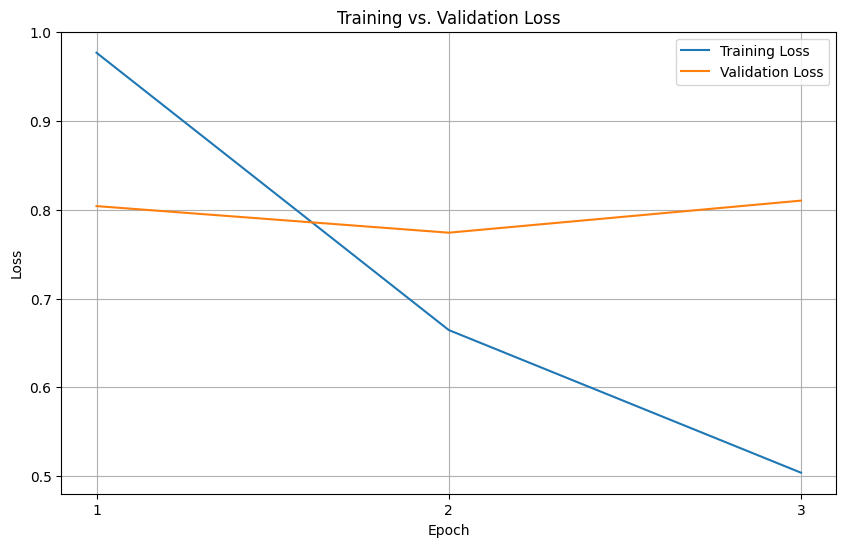

In [ ]:
# Training vs. validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(p4_final_history.history['loss'], label='Training Loss')
plt.plot(p4_final_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')

# Set x-ticks to be 1-indexed epoch numbers
plt.xticks(range(len(p4_final_history.history['loss'])), range(1, len(p4_final_history.history['loss']) + 1))
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

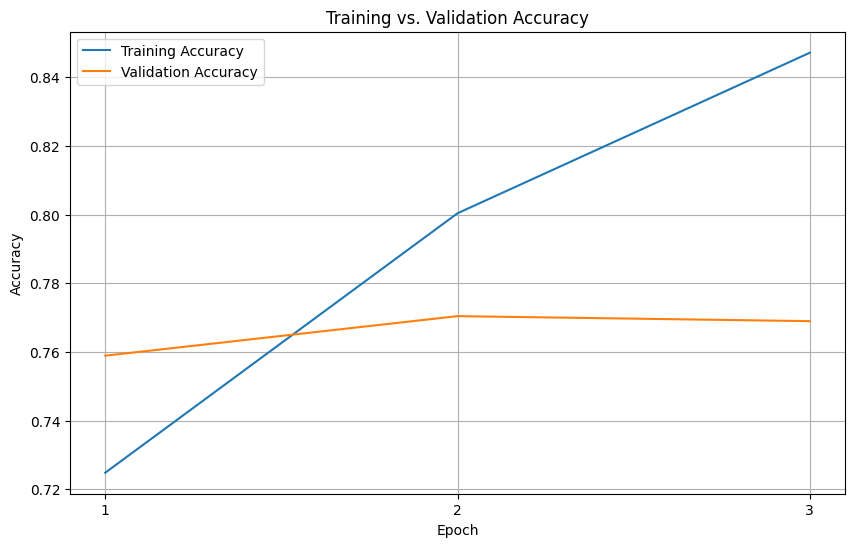

In [ ]:
# Training vs. validation accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(p4_final_history.history['accuracy'], label='Training Accuracy')
plt.plot(p4_final_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')

# Set x-ticks to be 1-indexed epoch numbers
plt.xticks(range(len(p4_final_history.history['accuracy'])), range(1, len(p4_final_history.history['accuracy']) + 1))
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

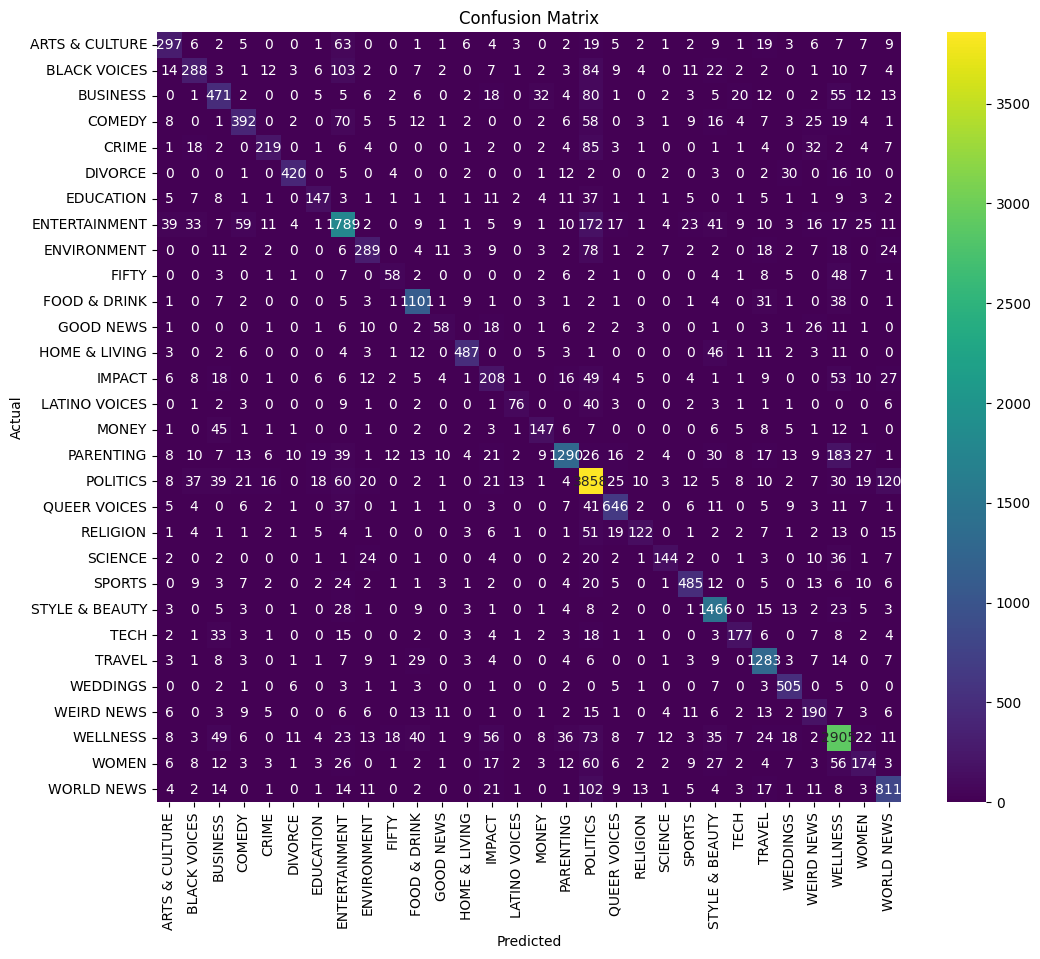

In [ ]:
# Confusion matrix using viridis using F1 scores
plt.figure(figsize=(12, 10))
cm = confusion_matrix(p4_final_y_test_np, p4_final_y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=p4_final_le.classes_, yticklabels=p4_final_le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Print the classification report using the original class labels
print("\nClassification Report:")
classification_report_str = classification_report(p4_final_y_test_np, p4_final_y_test_pred, target_names=p4_final_le.classes_)
print(classification_report_str)


Classification Report:
                precision    recall  f1-score   support

ARTS & CULTURE       0.69      0.62      0.65       481
  BLACK VOICES       0.65      0.47      0.55       610
      BUSINESS       0.62      0.62      0.62       759
        COMEDY       0.71      0.60      0.65       656
         CRIME       0.76      0.55      0.64       400
       DIVORCE       0.91      0.82      0.86       510
     EDUCATION       0.66      0.54      0.60       272
 ENTERTAINMENT       0.75      0.77      0.76      2330
   ENVIRONMENT       0.68      0.57      0.62       503
         FIFTY       0.53      0.37      0.44       157
  FOOD & DRINK       0.86      0.91      0.88      1214
     GOOD NEWS       0.54      0.38      0.44       154
 HOME & LIVING       0.90      0.81      0.85       601
        IMPACT       0.46      0.46      0.46       457
 LATINO VOICES       0.67      0.50      0.57       152
         MONEY       0.64      0.57      0.60       256
     PARENTING       0.

In [ ]:
# Print out a per-class frequency table
per_class_freq = pd.Series(p4_final_y_test_np).value_counts(normalize=True)
print("\nPer-Class Frequencies:")
print(per_class_freq)


Per-Class Frequencies:
17    0.163346
27    0.127537
7     0.087093
16    0.067656
22    0.059694
24    0.052592
10    0.045378
29    0.039622
18    0.030277
2     0.028371
3     0.024521
21    0.023324
1     0.022801
12    0.022465
25    0.020409
5     0.019063
8     0.018802
0     0.017979
13    0.017082
28    0.017007
4     0.014952
26    0.012073
23    0.011102
6     0.010167
19    0.009943
20    0.009868
15    0.009569
9     0.005869
11    0.005756
14    0.005682
Name: proportion, dtype: float64


## A.3.C: Final Test Metrics

In [ ]:
# Re-calculate the classification report as a dictionary
report_dict = classification_report(
    p4_final_y_test_np,
    p4_final_y_test_pred,
    target_names=p4_final_le.classes_,
    output_dict=True
)

# Extract overall metrics
overall_accuracy = report_dict['accuracy']
macro_f1_value = report_dict['macro avg']['f1-score']
weighted_f1_value = report_dict['weighted avg']['f1-score']

# Create a DataFrame from the per-class metrics
  # Exclude 'accuracy', 'macro avg', 'weighted avg' entries
df_per_class = pd.DataFrame.from_dict({
    k: v for k, v in report_dict.items() if k not in ['accuracy', 'macro avg', 'weighted avg']
}, orient='index')

# Calculate total observations for the OVERALL row
total_observations = df_per_class['support'].sum()

# Rename the 'f1-score' column to 'macro f1-score' for per-class data
df_per_class.rename(columns={'f1-score': 'macro f1-score'}, inplace=True)

# Add placeholder columns for accuracy and weighted f1-score in per-class df
  # This ensures column alignment for concatenation
df_per_class['accuracy'] = np.nan
df_per_class['weighted f1-score'] = np.nan

# Create the single 'OVERALL' summary row
summary_data = {
    'precision': np.nan,
    'recall': np.nan,
    'macro f1-score': macro_f1_value, # The actual overall macro F1 score goes here
    'support': total_observations, # Assign total observations here
    'accuracy': overall_accuracy,
    'weighted f1-score': weighted_f1_value
}
df_summary_row = pd.DataFrame([summary_data], index=['OVERALL'])

# Concatenate the per-class DataFrame and the new summary DataFrame
final_df_report = pd.concat([df_per_class, df_summary_row])

# Round numerical columns for better readability *before* type conversions/filling NaNs where possible
numerical_cols_to_round = ['precision', 'recall', 'macro f1-score', 'accuracy', 'weighted f1-score']
for col in numerical_cols_to_round:
    if col in final_df_report.columns:
        # Only round columns that are currently numeric (float)
        final_df_report.loc[:, col] = final_df_report.loc[:, col].apply(lambda x: round(x, 4) if pd.notna(x) else x)

# Handle 'support' column: convert to integer representation where possible, then to object for filling dash
  # Convert to Int64 first to correctly handle NaN as pd.NA and numbers as integers
final_df_report['support'] = final_df_report['support'].astype('Int64')
# Then, convert to string/object type to allow '-' for display
final_df_report['support'] = final_df_report['support'].astype(str)
# Finally, replace "<NA>" (from Int64.astype(str)) with '-'
final_df_report['support'] = final_df_report['support'].replace('<NA>', '-')

# Replace remaining NaN values with a dash for other columns (primarily for the summary row's precision/recall/f1-score columns)
final_df_report.fillna('-', inplace=True)

# Reset index and rename the index column to 'Category'
final_df_report = final_df_report.reset_index()
final_df_report.rename(columns={'index': 'Category'}, inplace=True)

# Reorder columns as requested
desired_column_order = [
    'Category',
    'precision',
    'recall',
    'support',
    'accuracy',
    'weighted f1-score',
    'macro f1-score'
]
final_df_report = final_df_report[desired_column_order]

# Capitalize the column names
final_df_report.columns = final_df_report.columns.str.capitalize()

# Convert to a dataframe
final_df_report = pd.DataFrame(final_df_report)


/tmp/ipython-input-410780195.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_df_report.fillna('-', inplace=True)


In [ ]:
# Display the final DataFrame
print("\nFinal Test Performance Report (Per Class and OVERALL Metrics):")
final_df_report


Final Test Performance Report (Per Class and OVERALL Metrics):


,Category,Precision,Recall,Support,Accuracy,Weighted f1-score,Macro f1-score
0,ARTS & CULTURE,0.6875,0.6175,481,-,-,0.6506
1,BLACK VOICES,0.6531,0.4721,610,-,-,0.5480
2,BUSINESS,0.6197,0.6206,759,-,-,0.6201
3,COMEDY,0.7114,0.5976,656,-,-,0.6495
4,CRIME,0.7631,0.5475,400,-,-,0.6376
5,DIVORCE,0.9071,0.8235,510,-,-,0.8633
6,EDUCATION,0.6622,0.5404,272,-,-,0.5951
7,ENTERTAINMENT,0.7536,0.7678,2330,-,-,0.7606
8,ENVIRONMENT,0.6752,0.5746,503,-,-,0.6208
9,FIFTY,0.5321,0.3694,157,-,-,0.4361
